<font size="4">
    


**ОПИСАНИЕ ЗАДАЧИ: прогнозирование содержания растворенного кислорода в речной воде**

 **Это соревнование другого типа!** Вместо отправки прогнозов задача состоит в том, чтобы отправить ** набор данных**, который будет использоваться для обучения модели регрессора случайного леса (предоставляется). Затем эта модель будет использоваться для составления прогнозов на основе скрытого тестового набора данных. Оценкой будет являться среднеквадратичная ошибка (RMSE) между предсказаниями модели и достоверностью результатов теста.

**О ДАННЫХ**

Набор данных содержит пять показателей, которые измеряются на 8 станциях государственной системы мониторинга водных ресурсов.

Показателями качества речной воды в этом наборе данных являются:
1. **O2_(i)**: Растворенный кислород (O2) измеряется в мгО2/куб. дм (т.е. миллиграммах кислорода (O2) в кубическом дециметре).;
2. **NH4_(i)**: Концентрация ионов аммония (NH4) измеряется в мг/куб. дм (т.е. миллиграммах на кубический дециметр).;
3. **NO2_(i)**: Концентрация нитрит-ионов (NO2) измеряется в мг/куб. дм (т.е. миллиграммах на кубический дециметр).;
4. **NO3_(i)**: Концентрация нитрат-ионов (NO3) измеряется в мг/куб. дм (т.е. миллиграммах на кубический дециметр).;
5. **BOD5_(i)**: Биохимическая потребность в кислороде, которая определяется через 5 дней ("BOD5" или "БПК"). BOD5 измеряется в мг/куб. дм (т.е. миллиграммах кислорода в кубическом дециметре).

где i - номер станции

**METRIC** ROOT MEAN SQUARED ERROR (RMSE)
   
</font>

# 2. IMPORTS

In [18]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import os

import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from copy import deepcopy
from functools import partial
from itertools import combinations

from sklearn.cluster import KMeans
!pip install --quiet yellowbrick
from yellowbrick.cluster import KElbowVisualizer
import folium
from haversine import haversine
import random
from random import uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
import statsmodels.api as sm
import math
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
!pip install --quiet optuna
import optuna
import xgboost as xgb
!pip install catboost
!pip install  --quiet lightgbm --install-option=--gpu --install-option="--boost-root=C:/local/boost_1_69_0" --install-option="--boost-librarydir=C:/local/boost_1_69_0/lib64-msvc-14.1"
import lightgbm as lgb
!pip install category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV, ElasticNetCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.ensemble import HistGradientBoostingRegressor,ExtraTreesRegressor,GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoost, CatBoostRegressor,CatBoostClassifier
from catboost import Pool
from sklearn.neighbors import KNeighborsRegressor
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --install-option


In [17]:
data=pd.read_csv("/kaggle/input/playground-series-s3e21/sample_submission.csv")

orig_train=pd.read_csv("/kaggle/input/dissolved-oxygen-prediction-in-river-water/train.csv")
orig_test=pd.read_csv("/kaggle/input/dissolved-oxygen-prediction-in-river-water/test.csv")

orig_train=orig_train.rename(columns={"Id":"id"})
orig_test=orig_test.rename(columns={"Id":"id"})

data_unmodified=data.copy()
data.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,0.200,0.650,14.515,5.845,1.285,0.429,0.030,0.050,0.064,0.730,1.075,0.056,0.567,0.400,1.500,1.560,19.355,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,1.027,1.848,8.625,12.175,0.280,0.440,0.089,1.360,0.064,0.902,1.454,0.056,0.190,2.347,5.105,2.095,19.355,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,0.020,0.650,17.144,24.645,0.380,0.440,0.060,0.050,0.082,0.902,2.025,0.056,0.567,1.700,1.700,3.960,4.900,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,0.270,1.730,3.870,8.410,1.480,1.380,0.050,0.050,0.070,0.530,1.740,0.050,0.064,1.500,1.500,2.020,3.960,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,0.435,0.650,3.850,5.845,0.280,0.440,0.105,0.115,0.074,1.252,1.075,0.071,0.190,1.050,1.150,2.095,3.902,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


# 3. Feature Importances

## Давайте сначала выясним порядок важности признаков в *НЕИЗМЕНЕННЫХ* данных

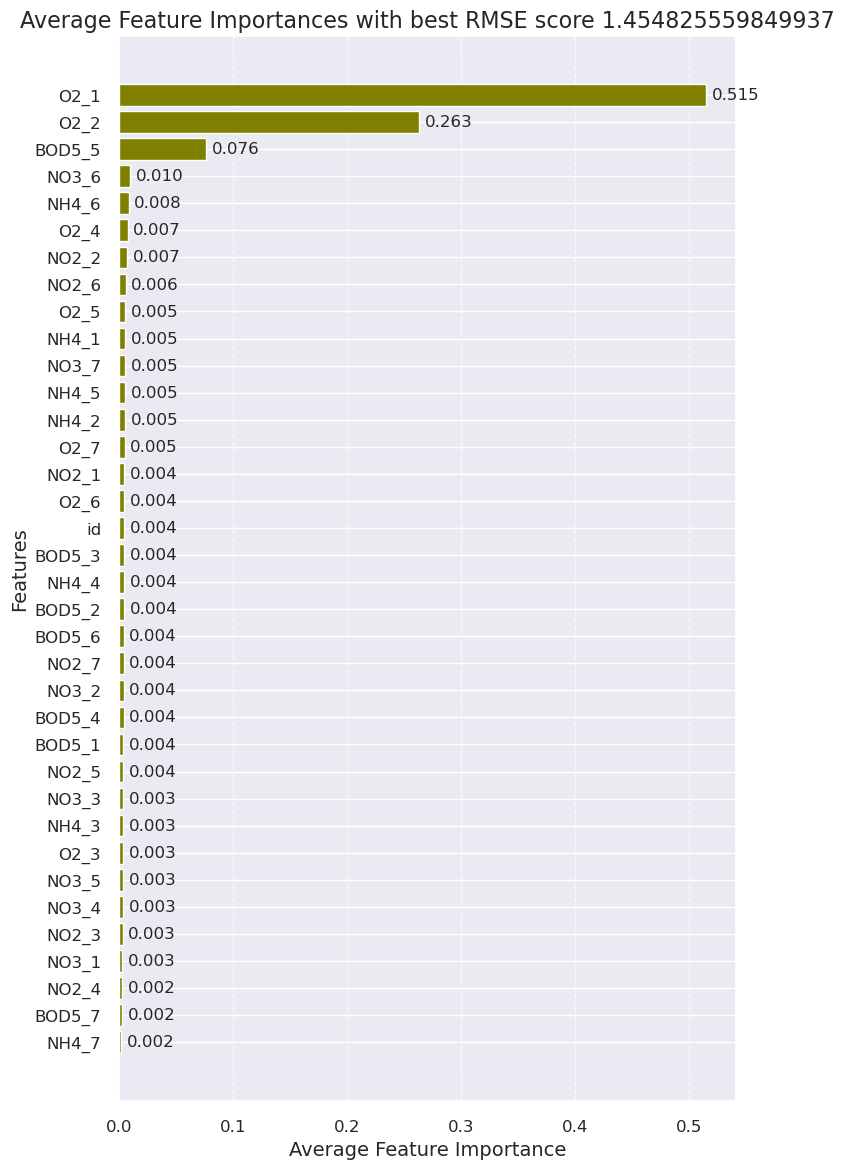

['O2_1', 'O2_2', 'BOD5_5', 'NO3_6', 'NH4_6', 'O2_4', 'NO2_2', 'NO2_6', 'O2_5', 'NH4_1', 'NO3_7', 'NH4_5', 'NH4_2', 'O2_7', 'NO2_1', 'O2_6', 'id', 'BOD5_3', 'NH4_4', 'BOD5_2', 'BOD5_6', 'NO2_7', 'NO3_2', 'BOD5_4', 'BOD5_1', 'NO2_5', 'NO3_3', 'NH4_3', 'O2_3', 'NO3_5', 'NO3_4', 'NO2_3', 'NO3_1', 'NO2_4', 'BOD5_7', 'NH4_7']


In [19]:
def rmse(y1,y2):
    return(np.sqrt(mean_squared_error(y1,y2)))
def get_most_important_features(data_modified, data_unmodified):
    
    X_train = data_modified.drop(columns=['target'])  
    y_train = data_modified['target'] 
    
    X_train_pure=data_unmodified.drop(columns=['target'])  
    y_train_pure=data_unmodified['target'] 
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    MAE = []
    feature_importances_list = []

    model = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)

    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train_pure.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train_pure.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_val_fold)

        mae = rmse(y_val_fold, y_pred)
        MAE.append(mae)

        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_mae = np.mean(MAE)

    # Calculate average feature importances over all folds
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]

    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    list_features=[feature[0] for feature in sorted_features]
    
    feature_names, importances = zip(*sorted_features)

    plt.figure(figsize=(8, 12))
    plt.barh(range(len(feature_names)), importances, color='olive')
    plt.yticks(range(len(feature_names)), feature_names, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(f'Average Feature Importances with best RMSE score {avg_mae}', fontsize=16)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    for index, value in enumerate(importances):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return list_features, avg_mae

list_features,best_score = get_most_important_features(data, data)
print(list_features)


# 4. Original Data

### Исключите любую возможность утечки данных!

<font size="4">  Какие бы изменения мы ни вносили в данный набор данных, давайте проверим работоспособность модели на исходных данных. Это даст нам объективное представление о манипулировании данными</font>



In [20]:
table = PrettyTable()

table.field_names = ['Column Name', 'Data Type', "Mising %", 'Original Missing %']
for column in data.columns:
    data_type = str(data[column].dtype)
    non_null_count_train= np.round(100-orig_train[column].count()/orig_train.shape[0]*100,1)
    non_null_count_data = np.round(100-data[column].count()/data.shape[0]*100,1)
    table.add_row([column, data_type,non_null_count_data, non_null_count_train])
print(table)

+-------------+-----------+----------+--------------------+
| Column Name | Data Type | Mising % | Original Missing % |
+-------------+-----------+----------+--------------------+
|      id     |   int64   |   0.0    |        0.0         |
|    target   |  float64  |   0.0    |        0.0         |
|     O2_1    |  float64  |   0.0    |        1.4         |
|     O2_2    |  float64  |   0.0    |        1.4         |
|     O2_3    |  float64  |   0.0    |        78.2        |
|     O2_4    |  float64  |   0.0    |        78.9        |
|     O2_5    |  float64  |   0.0    |        77.6        |
|     O2_6    |  float64  |   0.0    |        74.8        |
|     O2_7    |  float64  |   0.0    |        74.8        |
|    NH4_1    |  float64  |   0.0    |        1.4         |
|    NH4_2    |  float64  |   0.0    |        1.4         |
|    NH4_3    |  float64  |   0.0    |        78.2        |
|    NH4_4    |  float64  |   0.0    |        78.9        |
|    NH4_5    |  float64  |   0.0    |  

### Обнулите столбцы, основываясь на том, что в исходных данных отсутствует %
<font size="4">Во многих столбцах отсутствует более 70% значений. Давайте исключим эти столбцы, обнулив их. Мы оставим только BOD5_5, в котором также отсутствует более 70%, но это оказалось важной особенностью</font>

<font size="4">Пожалуйста, обратите внимание, что для наиболее важных функций O2_1 и O2_2 не хватает всего 1,4%, мы также обнулим столбцы в данном наборе данных</font>


In [21]:
'''make columns with more than 70% missing zero except BOD5_5'''
data_zeroed=data.copy()

for col in orig_train.columns:
    if col not in ['BOD5_5']:
        if orig_train[col].isna().sum()/orig_train.shape[0]>0.7:
            orig_train[col]=0
            data_zeroed[col]=0
orig_train['id']=0
data_zeroed['id']=0

Этот код выполняет заполнение пропущенных значений в числовых признаках датасета с использованием итеративного подхода, комбинируя два алгоритма машинного обучения: LightGBM и CatBoost. 

Iterations: 100%|██████████| 100/100 [05:39<00:00,  3.39s/it]


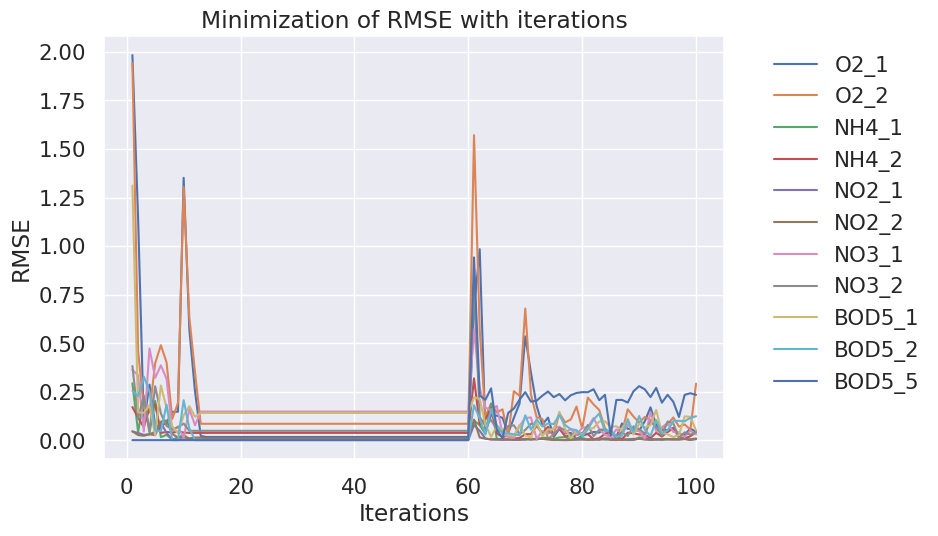

In [22]:
cb_params = {
            'iterations': 200,
            'depth': 6,
            'learning_rate': 0.008,
            'l2_leaf_reg': 0.5,
            'random_strength': 0.2,
            'max_bin': 150,
            'od_wait': 80,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'IncToDec',
            'eval_metric': 'RMSE',
            'loss_function': 'RMSE',
            'random_state': 42,
        }
lgb_params = {
            'n_estimators': 100,
            'max_depth': 6,
            "num_leaves": 16,
            'learning_rate': 0.05,
            'subsample': 0.7,
            'colsample_bytree': 0.8,
            #'reg_alpha': 0.25,
            'reg_lambda': 5e-07,
            'objective': 'regression_l2',
            'metric': 'mean_squared_error',
            'boosting_type': 'gbdt',
            'random_state': 42
        }
def rmse(y1,y2):
    return(np.sqrt(mean_squared_error(y1,y2)))

def store_missing_rows(df, features):
    missing_rows = {}
    
    for feature in features:
        missing_rows[feature] = df[df[feature].isnull()]
    
    return missing_rows
def fill_missing_numerical(train,target, max_iterations=10):
    
    df=train.drop(columns=[target])
    df=df.reset_index(drop=True)
    
    features=[f for f in df.columns if df[f].isna().sum()>0]
    # Step 1: Store the instances with missing values in each feature
    missing_rows = store_missing_rows(df, features)
    
    # Step 2: Initially fill all missing values with "Median"
    for f in features:
        df[f]=df[f].fillna(df[f].mean())
    
    cat_features=[f for f in df.columns if df[f].dtype=="O"]
    dictionary = {feature: [] for feature in features}
    
    for iteration in tqdm(range(max_iterations), desc="Iterations"):
        for feature in features:
            # Skip features with no missing values
            rows_miss = missing_rows[feature].index
            
            missing_temp = df.loc[rows_miss].copy()
            non_missing_temp = df.drop(index=rows_miss).copy()
            y_pred_prev=missing_temp[feature]
            missing_temp = missing_temp.drop(columns=[feature])
            
            
            X_train = non_missing_temp.drop(columns=[feature])
            y_train = non_missing_temp[[feature]]
            if iteration/max_iterations<0.6:
                model= lgb.LGBMRegressor(**lgb_params)
                model.fit(X_train, y_train, verbose=False)
            else:
                model = CatBoostRegressor(**cb_params)
                model.fit(X_train, y_train, verbose=False)
            
            # Step 4: Predict missing values for the feature and update all N features
            y_pred = model.predict(missing_temp)
            df.loc[rows_miss, feature] = y_pred
            error_minimize=rmse(y_pred,y_pred_prev)
            dictionary[feature].append(error_minimize)  # Append the error_minimize value

    for feature, values in dictionary.items():
        iterations = range(1, len(values) + 1)  # x-axis values (iterations)
        plt.plot(iterations, values, label=feature)  # plot the values
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title('Minimization of RMSE with iterations')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    train[features] = np.array(df[features])

    return train

orig_train_filled = fill_missing_numerical(orig_train,"target",100)

\

# 5. Cross Validation Function

### A function to eliminate data leakages!

<font size="3"> 
Поскольку изменение данных неизбежно в условиях конкуренции, это может быть сделано любыми способами, такими как обрезка, обнуление столбцов, удаление строк. Я сконструировал нижеприведенную функцию для явной проверки производительности измененных данных на неизмененных данных и гарантировал, что разделение для проверки отличается от обучающих данных. 
    
В случае, когда строки в измененных данных удаляются, обновленные данные также будут проверены на соответствующих строках, которые были удалены в данных. 
    
Исходные данные также оцениваются, и на основе количества точек данных вычисляется взвешенный RMSE
</font>


In [23]:
def score_check_unbiased(data_modified, data_unmodified,original, n_estimators,Print):
    X_train = data_modified.drop(columns=['target'])  
    y_train = data_modified['target'] 
    
    X_train_pure=data_unmodified.drop(columns=['target'])  
    y_train_pure=data_unmodified['target'] 
    
    X_test=original.drop(columns=['target'])
    y_test=original['target']
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=7, n_jobs=-1, random_state=42) 
    RMSE_pure = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train_pure.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train_pure.iloc[val_idx]
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_val_fold)
        rmse_pure = rmse(y_val_fold, y_pred)
        RMSE_pure.append(rmse_pure)
    model.fit(X_train,y_train)
    y_pred_orig=model.predict(X_test)
    rmse_orig=rmse(y_test,y_pred_orig)
    if Print is True:
        print(f"RMSE on unmodified data is {np.mean(RMSE_pure)} and RMSE on original data is {rmse_orig} ")
    '''
    Weights to compute RMSE combined is based on # of available datapoints
    
    '''
    
    rmse_combined=(X_train.shape[0]*np.mean(RMSE_pure)+original.shape[0]*rmse_orig)/(X_train.shape[0]+original.shape[0])
    return rmse_combined

In [24]:
print(f"Performance on Unmodified Data & Original Data has RMSE Score :{score_check_unbiased(data_zeroed,data_unmodified,orig_train, n_estimators=50,Print=True)}")

RMSE on unmodified data is 1.446943430290967 and RMSE on original data is 1.6623654676405517 
Performance on Unmodified Data & Original Data has RMSE Score :1.4556264682647506


# 6. Feature Clipping/Dropping Optimization

## Optuna is Bayesian Optimization, specifically the Tree-structured Parzen Estimator (TPE) algorithm.
<font size="4">

Optuna uses a combination of different algorithms and heuristics to efficiently search the hyperparameter space and find the set of hyperparameters that minimizes the objective function.

**Search Space:** To find the right lower bound and upper bound to clip  feature/or drop rows, we will use standard deviation from median. 
    
- Lower Bound Space: [Column Minimum, Median- 4 * Standrad Deviation]
- Upper Bound Space: [Median+ 1 * Standrad Deviation, Column Maximum]

**Objective:** Minimize RMSE score of original data
    
**Early Stopping Criteria:** If the best trial score is being repeated for N consecutive times
    
**Note:** Start Optimizing from the least important non zero feature in order reflect small changes and see if they can improve performance</font>

</font>


## Optuna - это байесовская оптимизация, в частности, древовидный алгоритм оценки Парцена (THE).

Options использует комбинацию различных алгоритмов и эвристик для эффективного поиска в пространстве гиперпараметров и нахождения набора гиперпараметров, который минимизирует целевую функцию.

**Область поиска** Чтобы найти правильную нижнюю границу и верхнюю границу для обрезки объектов или удаления строк, мы будем использовать стандартное отклонение от медианы. 
    
- - Пространство для нижней границы: [Минимум столбца, медиана- 4 * Стандартное отклонение]
- - Интервал между верхними границами: [Медиана+ 1 * Стандартное отклонение, максимальное значение в столбце]

**Цель:** Минимизировать оценку RMSE исходных данных
    
**Критерии досрочного прекращения:** Если наилучшая оценка в ходе испытания повторяется N раз подряд
    
**Примечание:** Начните оптимизацию с наименее важной ненулевой функции, чтобы отразить небольшие изменения и посмотреть, могут ли они улучшить производительность</font>



In [26]:
max_consecutive_best_count = 25  # Set N to the desired number of consecutive best scores to trigger early stopping

best_trial_number = 0
import logging

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial, data_new, data_unmodified,orig_train, column):
    
    upper_upper = data_new[column].max()
    upper_lower=data_new[column].median() + 4 * data_new[column].std()
    if upper_lower>=upper_upper:
        upper_lower=0.99*upper_upper
        
    lower_lower = data_new[column].min()
    if column=="target":
        lower_upper=data_new[column].median() - 1e-1
    else:
        lower_upper=data_new[column].median() - 2 * data_new[column].std()
    
#     lower_upper=data_new[column].median() - 1e-5

    if lower_upper<=lower_lower:
        lower_upper=lower_lower+1e-2
    
    
    upper_threshold = trial.suggest_float('upper_threshold',upper_lower, upper_upper)
    lower_threshold = trial.suggest_float('lower_threshold', lower_lower,lower_upper )
    
    modified_data = data_new.copy()
    modified_data[column] = modified_data[column].clip(lower_threshold, upper_threshold)
    
    mask = (data_new[column] >= lower_threshold) & (data_new[column] <= upper_threshold)
    masked_data=data_new[mask]
    score1 = score_check_unbiased(modified_data,data_unmodified,orig_train, 20,Print=False)

    if masked_data.shape[0]==0:
        return score1
    else:
        score2 = score_check_unbiased(masked_data,data_unmodified,orig_train, 20,Print=False)
        return min(score1,score2)

def early_stopping_callback(study, trial, max_consecutive_best_count):
    global best_trial_number
    
    if study.best_trial.number > best_trial_number:
        best_trial_number = study.best_trial.number
    else:
        best_trial_number = study.best_trial.number
    
    if trial.number - best_trial_number >= max_consecutive_best_count:
        print(f"Stopped Early: Same best score for {max_consecutive_best_count} consecutive trials.")
        study.stop()
def get_dataset_with_min_score(score_initial, score_clipped, score_dropped, data_new, data_clipped, data_dropped):
    scores_to_datasets = {
        score_initial: data_new,
        score_clipped: data_clipped,
        score_dropped: data_dropped
    }

    min_score = min(score_initial, score_clipped, score_dropped)
    dataset_with_min_score = scores_to_datasets[min_score]

    return dataset_with_min_score

def optimize_thresholds(data_new,data_unmodified,orig_train, column, n_trials, max_consecutive_best_count):
    data_clipped=data_new.copy()
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, data_new, data_unmodified,orig_train, column), n_trials=n_trials,\
                   callbacks=[lambda study, trial: early_stopping_callback(study, trial, max_consecutive_best_count)])

    best_upper_threshold = study.best_params['upper_threshold']
    best_lower_threshold = study.best_params['lower_threshold']

    print(f"Best lower & upper thresholds for column {column} ----------> ({best_lower_threshold},{best_upper_threshold})" )
    
    data_clipped[column] = data_new[column].clip(best_lower_threshold-1e-5, best_upper_threshold+1e5)
    mask = (data_new[column] >= best_lower_threshold) & (data_new[column] <= best_upper_threshold)
    
    data_dropped=data_new[mask]
#     print(data_dropped[column].min(),data_dropped[column].max())
#     print(data_clipped[column].min(),data_clipped[column].max())
#     print(data_new[column].min(),data_new[column].max())

    
    score_initial=score_check_unbiased(data_new,data_unmodified,orig_train, 100,Print=False)
    score_clipped= score_check_unbiased(data_clipped,data_unmodified,orig_train, 100,Print=False)
    score_dropped=score_check_unbiased(data_dropped,data_unmodified,orig_train, 100,Print=False)
    
    print(f"RMSE Score on Unchanged Data after Clipping Column {column} is {min(score_initial,score_clipped,score_dropped)}")
    return_data=get_dataset_with_min_score(score_initial, score_clipped, score_dropped, data_new, data_clipped, data_dropped)
#     print(return_data[column].min(),return_data[column].max())
    return return_data

In [27]:
data_new=data_zeroed.copy()

non_zero_cols=[f for f in data_new.columns if np.sum(data_new[f])!=0]

list_features_non_important=list_features[::-1] # reverse the list based on least importance first

ordered_non_zero_features=[f for f in list_features_non_important if f in non_zero_cols]

### Based on the above algorithm, Lets, clip/drop , whichever is best. I will start with target followed by features and target again at last


In [28]:
data_new = optimize_thresholds(data_new,data_unmodified,orig_train, 'target',300, max_consecutive_best_count)

for col in ordered_non_zero_features:
    data_new=optimize_thresholds(data_new, data_unmodified,orig_train, col,200, max_consecutive_best_count) # maximum of 200 trials
    print("____________________________________________________________________________________________________")
data_new = optimize_thresholds(data_new,data_unmodified,orig_train, 'target',300, max_consecutive_best_count)

Stopped Early: Same best score for 25 consecutive trials.
Best lower & upper thresholds for column target ----------> (4.006680186938264,43.885156804409554)
RMSE Score on Unchanged Data after Clipping Column target is 1.187866973868485
Stopped Early: Same best score for 25 consecutive trials.
Best lower & upper thresholds for column NO3_1 ----------> (0.0048534734001300555,23.860229203237534)
RMSE Score on Unchanged Data after Clipping Column NO3_1 is 1.1827568126814296
____________________________________________________________________________________________________
Stopped Early: Same best score for 25 consecutive trials.
Best lower & upper thresholds for column BOD5_1 ----------> (0.5722105239510429,11.605186274285119)
RMSE Score on Unchanged Data after Clipping Column BOD5_1 is 1.1827568126814296
____________________________________________________________________________________________________
Stopped Early: Same best score for 25 consecutive trials.
Best lower & upper threshol

In [29]:
print(f"Number data points after optimizing thresholds {data_new.shape[0]}")

Number data points after optimizing thresholds 3473


# 7. Feature Importance- Post Clipping

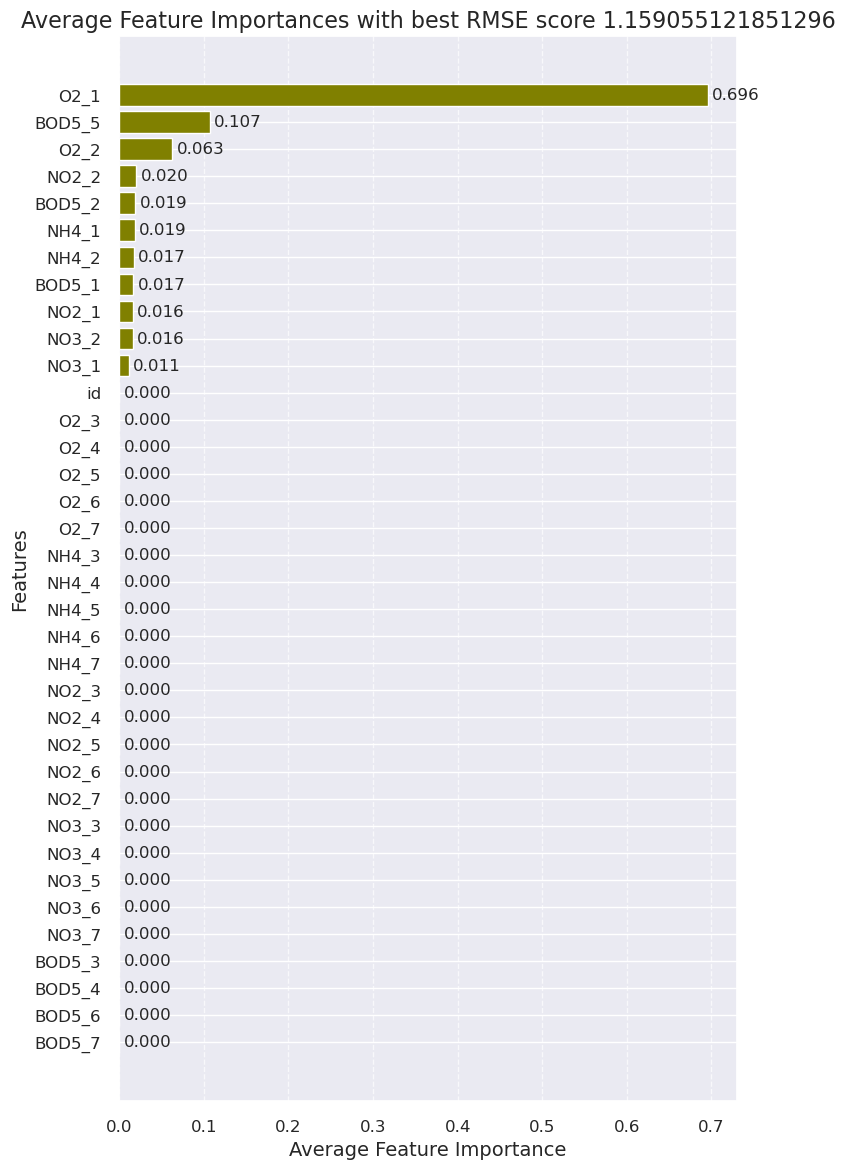

['O2_1', 'BOD5_5', 'O2_2', 'NO2_2', 'BOD5_2', 'NH4_1', 'NH4_2', 'BOD5_1', 'NO2_1', 'NO3_2', 'NO3_1', 'id', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_3', 'NO3_4', 'NO3_5', 'NO3_6', 'NO3_7', 'BOD5_3', 'BOD5_4', 'BOD5_6', 'BOD5_7']


In [30]:
list_features,best_score = get_most_important_features(data_new, data_unmodified)
print(list_features)

# 8. Outlier Detection

## SGDOneClassSVM



Этот код использует одноклассовую SVM для обнаружения выбросов в данных. Он обучает модель, предсказывает выбросы, добавляет столбец с метками выбросов, очищает данные от выбросов и вычисляет RMSE для очищенных данных. В конце функция возвращает исходный DataFrame с добавленным столбцом, указывающим, какие строки являются выбросами.

In [31]:
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

def one_class_SVM(data_new):
    data=data_new.copy()
    model= SGDOneClassSVM(nu=0.013698571895715758)
    model.fit(data)
    predicted_labels = model.predict(data)
    outliers = predicted_labels == -1
    data['outlier_One_SVM'] = outliers
    identified_outliers = data[data['outlier_One_SVM']]
    print(f"Number of detected Potential outliers: {identified_outliers.shape[0]}")
    
    data_clean=data[~data['outlier_One_SVM']].drop(columns=['outlier_One_SVM'])
    print(f"RMSE Score without the identified outliers is {score_check_unbiased(data_clean,data_unmodified,orig_train,200,Print=True)}")
    
    return data
data_svm= one_class_SVM(data_new)

Number of detected Potential outliers: 2
RMSE on unmodified data is 1.2295525678799906 and RMSE on original data is 1.696064274361066 
RMSE Score without the identified outliers is 1.2485070236159546


### Hyperparameter Tuning

In [ ]:
# def objective(trial,data_pure):
#     data=data_new.copy()
#     nu = trial.suggest_float('nu', 0.01, 1.0)  #
#     model = SGDOneClassSVM(nu=nu)
#     model.fit(data)

#     predicted_labels = model.predict(data)

#     # Convert predicted labels to identify outliers (predicted as -1)
#     outliers = predicted_labels == -1

#     data['outlier_One_SVM'] = outliers

#     # Compute the score using score_check_unbiased
#     data_clean = data[~data['outlier_One_SVM']]
#     data_clean=data_clean.drop(columns=["outlier_One_SVM"])
#     score = score_check_unbiased(data_clean,data_unmodified,orig_train,50,Print=False)

#     return score

# study = optuna.create_study(direction='minimize')

# study.optimize(lambda trial: objective(trial,data_new), n_trials=100)  

# best_params = study.best_params
# best_params

## IsolationForest

In [32]:
from sklearn.ensemble import IsolationForest

def isolation_forest(data_new):
    data=data_new.copy()
    model = IsolationForest(contamination=0.010650427383702971, random_state=0)

    model.fit(data)

    # Predict the anomaly scores for each data point
    anomalies = model.predict(data)

    outliers = anomalies == -1

    # Combine the outlier information with the original data and labels
    data['outlier_ISF'] = outliers

    # Print the identified outliers
    identified_outliers = data[data['outlier_ISF']]
    print(f"Number of detected Potential outliers: {identified_outliers.shape[0]}")
    
    data_clean=data[~data['outlier_ISF']].drop(columns=["outlier_ISF"])
    print(data_clean.shape)
    print(f"RMSE Score after without the identified outliers is {score_check_unbiased(data_clean,data_unmodified,orig_train,200,Print=True)}")
    
    return data
data_isf=isolation_forest(data_new)

Number of detected Potential outliers: 37
(3436, 37)
RMSE on unmodified data is 1.3295180608220103 and RMSE on original data is 1.6618013477492026 
RMSE Score after without the identified outliers is 1.3431506712541332


### Hyperparameter Tuning

In [ ]:
# from sklearn.ensemble import IsolationForest
# import optuna

# def objective(trial, data_new):
#     data = data_new.copy()
#     contamination = trial.suggest_float('contamination', 0.01, 0.5)  # Tune the 'contamination' hyperparameter within a range
#     model = IsolationForest(contamination=contamination, random_state=0)
#     model.fit(data_new)

#     predicted_labels = model.predict(data_new)

#     outliers = predicted_labels == -1

#     data['outlier_Isolation_Forest'] = outliers

#     data_clean = data[~data['outlier_Isolation_Forest']]
#     data_clean = data_clean.drop(columns=["outlier_Isolation_Forest"])
#     score = score_check_unbiased(data_clean,data_unmodified,orig_train,200,Print=True)

#     return score

# study = optuna.create_study(direction='minimize')

# study.optimize(lambda trial: objective(trial, data_new), n_trials=100)

# best_params = study.best_params
# best_params

### Hyperparameter Tuning

##  Local Outlier Factor(LOF)

In [33]:
from sklearn.neighbors import LocalOutlierFactor

params={'n_neighbors': 8, 'contamination': 0.014191232244600834}

def lof(data_new):
    data=data_new.copy()
    lof = LocalOutlierFactor(**params)  # Adjust contamination based on your data
    anomalies = lof.fit_predict(data)  # Negative scores are outliers

    outliers = anomalies == -1

    # Combine the outlier information with the original data and labels
    data['outliers_LOF'] = outliers

    # Print the identified outliers
    identified_outliers = data[data['outliers_LOF']]
    print(f"Number of detected Potential outliers: {identified_outliers.shape[0]}")
    
    data_clean=data[~data['outliers_LOF']].drop(columns=['outliers_LOF'])
    print(data_clean.shape)
    print(f"RMSE Score after without the identified outliers is {score_check_unbiased(data_clean,data_unmodified,orig_train,200,Print=True)}")
    
    return data
data_lof=lof(data_new)

Number of detected Potential outliers: 50
(3423, 37)
RMSE on unmodified data is 1.1834527003575428 and RMSE on original data is 1.597485560052378 
RMSE Score after without the identified outliers is 1.2005011122273301


### Hyperparameter Tuning

In [ ]:
# # Define the objective function for hyperparameter optimization
# def objective(trial, data_new, list_features):
#     data = data_new.copy()

#     # Define hyperparameters to tune
#     n_neighbors = trial.suggest_int('n_neighbors', 3, 20)  # Adjust this based on your data
#     contamination = trial.suggest_float('contamination', 0.01, 0.5)

#     model = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
#     predicted_labels = model.fit_predict(data_new)

#     # Identify potential outliers
#     outliers = predicted_labels == -1

#     data['outlier_LOF'] = outliers

#     # Compute the score using score_check_unbiased
#     data_clean = data[~data['outlier_LOF']].drop(columns=['outlier_LOF'])
#     score = score_check_unbiased(data_clean,data_unmodified,orig_train,200,Print=True)

#     return score

# # Create an Optuna study for minimization
# study = optuna.create_study(direction='minimize')

# # Optimize hyperparameters
# study.optimize(lambda trial: objective(trial, data_new, list_features), n_trials=100)

# # Get the best hyperparameters
# best_params = study.best_params

# best_params

## PCA

Number of detected Potential outliers: 8
(3465, 37)
RMSE on unmodified data is 1.3293242320024425 and RMSE on original data is 1.6694754235153821 
RMSE Score after without the identified outliers is 1.3431675944477364


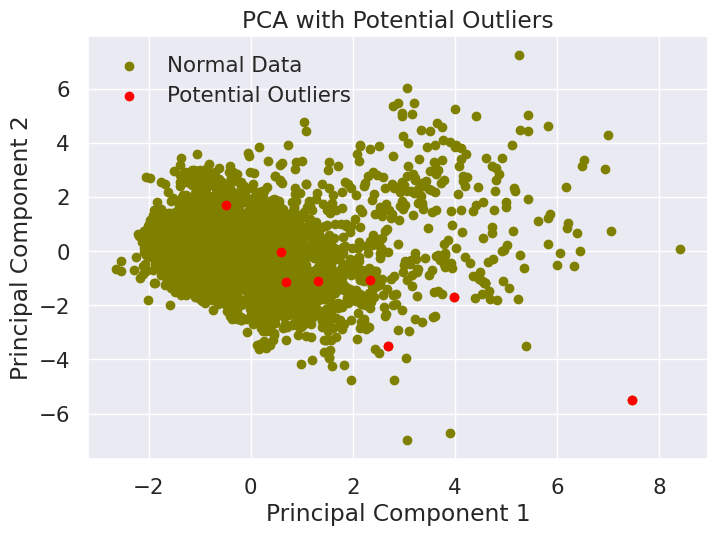

In [34]:
def pca_anamolies( data_new):
    data =data_new.copy()
    features=data.columns
    scaler = StandardScaler()

    pca = PCA(n_components=2)  
    principal_components = pca.fit_transform(scaler.fit_transform(data))

    reconstruction_errors = ((scaler.fit_transform(data) - pca.inverse_transform(principal_components)) ** 2).mean(axis=1)

    threshold = 4

    potential_outliers = [index for index, error in enumerate(reconstruction_errors) if error > threshold]
    data['outliers_PCA']=reconstruction_errors
    data['outliers_PCA'] = np.where(reconstruction_errors>4 , True, False)
#     data.loc[potential_outliers, 'outliers_PCA'] = True

    print(f"Number of detected Potential outliers: {len(potential_outliers)}")
    
    data_clean=data[~data['outliers_PCA']].drop(columns=['outliers_PCA'])
    print(data_clean.shape)
    print(f"RMSE Score after without the identified outliers is {score_check_unbiased(data_clean,data_unmodified,orig_train,200,Print=True)}")

    plt.scatter(principal_components[:, 0], principal_components[:, 1], c='olive', label='Normal Data')
    plt.scatter(principal_components[potential_outliers, 0], principal_components[potential_outliers, 1], c='red', label='Potential Outliers')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.title('PCA with Potential Outliers')
    plt.show()
    return data
data_pca=pca_anamolies(data_new)

In [35]:
data_new['outliers']=data_svm["outlier_One_SVM"]|data_isf["outlier_ISF"]|data_lof["outliers_LOF"]|data_pca["outliers_PCA"]
final_data=data_new[~data_new["outliers"]].drop(columns=['outliers'])
data_new=data_new.drop(columns=['outliers'])
print(f"{data_new.shape[0]-final_data.shape[0]} datapoints are identfied as outliers from four techniques")

89 datapoints are identfied as outliers from four techniques


In [36]:
print(f"Number data points after removing outliers {final_data.shape[0]}")

Number data points after removing outliers 3384


In [37]:
'''Call the target optimizing functionto know if the threshold changes'''
final_data = optimize_thresholds(final_data,data_unmodified,orig_train, 'target',300, max_consecutive_best_count)

Stopped Early: Same best score for 25 consecutive trials.
Best lower & upper thresholds for column target ----------> (4.166535717824105,19.135910910913633)
RMSE Score on Unchanged Data after Clipping Column target is 1.339296610780289


# 9. Feature Importance- Post Outliers

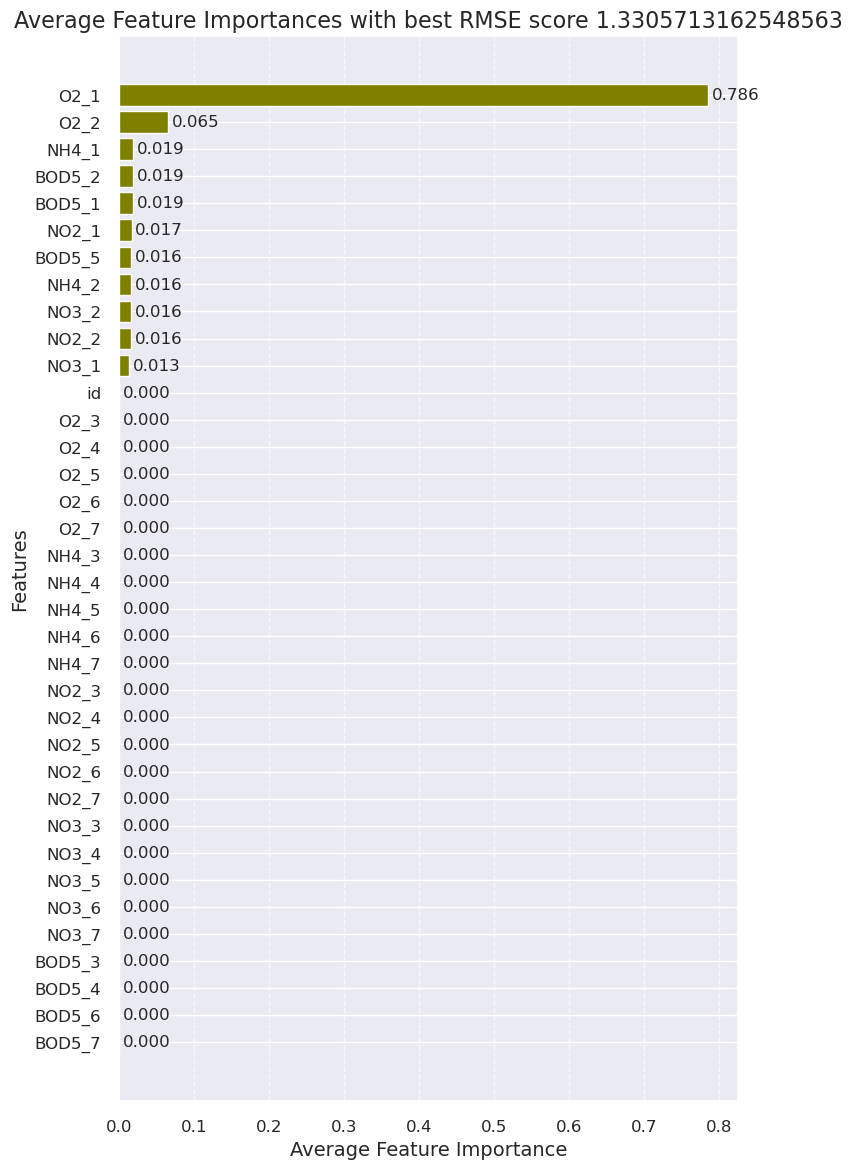

['O2_1', 'O2_2', 'NH4_1', 'BOD5_2', 'BOD5_1', 'NO2_1', 'BOD5_5', 'NH4_2', 'NO3_2', 'NO2_2', 'NO3_1', 'id', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_3', 'NO3_4', 'NO3_5', 'NO3_6', 'NO3_7', 'BOD5_3', 'BOD5_4', 'BOD5_6', 'BOD5_7']


In [38]:
list_features,best_score = get_most_important_features(final_data, data_unmodified)
print(list_features)

# 10. Feature Selection- Forward Approach

<font size="3"> Let's get the Feature Importances of all the columns and do a forward selection to find the optimum columns that can minimize RMSE score </font>

In [40]:
def feature_selection(data_modified,data_unmodified,original,list_features):
    random_seed = random.randint(0, 9999)
    
    X_train = data_modified.drop(columns=['target'])  
    y_train = data_modified['target'] 
    
    X_train_pure=data_unmodified.drop(columns=['target'])  
    y_train_pure=data_unmodified['target'] 
    
    X_test= original.drop(columns=['target'])  
    y_test = original['target'] 
    
    model = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42) #reduced the estimators to make the process faster
    previous_rmse= float('inf')
    for i in range(1,len(list_features)):
        X_train_selected=X_train[list_features[:i]]
        X_train_pure_selected=X_train_pure[list_features[:i]]
        RMSE = []
        kfold = KFold(n_splits=5, shuffle=True, random_state=random_seed)
        for train_idx, val_idx in kfold.split(X_train_selected):
            X_train_fold, X_val_fold = X_train_selected.iloc[train_idx], X_train_pure_selected.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train_pure.iloc[val_idx]

            model.fit(X_train_fold, y_train_fold)

            y_pred = model.predict(X_val_fold)

            mae = rmse(y_val_fold, y_pred)
            RMSE.append(mae)
            
        model.fit(X_train_selected,y_train)
        y_pred_orig=model.predict(X_test[list_features[:i]])
        rmse_orig=rmse(y_test,y_pred_orig)

        rmse_combined=(X_train.shape[0]*np.mean(RMSE)+original.shape[0]*rmse_orig)/(X_train.shape[0]+original.shape[0])
        if rmse_combined<=previous_rmse:
            print(f"score {rmse_combined} improved by adding a feature") 
        else:
            print(f"No further improvement by adding columns, consider {i} features")
            n=i
            break
        previous_rmse=rmse_combined
    return n

In [41]:
best_features=list_features[:feature_selection(final_data,data_unmodified,orig_train,list_features)]

score 1.4119946077026067 improved by adding a feature
score 1.374317447798372 improved by adding a feature
score 1.3679535611095304 improved by adding a feature
score 1.3634902847860157 improved by adding a feature
score 1.3574308426738921 improved by adding a feature
score 1.354614891045019 improved by adding a feature
score 1.3503544885784773 improved by adding a feature
score 1.3487079701150835 improved by adding a feature
score 1.347511267962694 improved by adding a feature
score 1.3461513923339963 improved by adding a feature
score 1.3458438698118238 improved by adding a feature
No further improvement by adding columns, consider 12 features


In [42]:
zero_features=[f for f in final_data.columns if f not in best_features+['target']]
for col in zero_features:
    final_data[col]=0

In [43]:
print(f"Final RMSE score is {score_check_unbiased(final_data,data_unmodified,orig_train,1000,Print=True)}")

RMSE on unmodified data is 1.3305713162548563 and RMSE on original data is 1.6011461616971983 
Final RMSE score is 1.3418420734892071


## Let's make a full submission by replicating important points

In [44]:
final_data=final_data.reset_index(drop=True)
from sklearn.model_selection import cross_val_predict
from collections import OrderedDict

def compute_rmse_contributions(X, y, n_estimators=25, max_depth=7, random_state=42):
    """
    Compute the RMSE contribution for each data point using cross-validation.
    """

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Calculate RMSE for each data point using cross-validation
    predicted_y = cross_val_predict(model, X, y, cv=5)  # You can adjust cv as needed

    # Calculate RMSE for each data point
    rmse_contributions = []
    for i in range(len(X)):
        y_true_i = y.iloc[i] if isinstance(y, pd.Series) else y[i]
        y_pred_i = predicted_y[i]
#         print([y_true_i], [y_pred_i])
        rmse_i = np.sqrt(mean_squared_error([y_true_i], [y_pred_i]))
        rmse_contributions.append((i, rmse_i))

    # Sort RMSE contributions in decreasing order
    sorted_rmse_contributions = OrderedDict(sorted(rmse_contributions, key=lambda x: x[1], reverse=True))

    return sorted_rmse_contributions

X=final_data.drop(columns=['target'])
y=final_data['target']
sorted_rmse_contributions = compute_rmse_contributions(X, y)


In [45]:
N=3500-final_data.shape[0]

best_datapoints= list(sorted_rmse_contributions.keys())[-N:]

print("Best Indexes with High RMSE:")
for index in best_datapoints:
    rmse = sorted_rmse_contributions[index]
    print(f"Index {index}: RMSE = {rmse}")
    
additional_rows=final_data.loc[best_datapoints]
final_data=pd.concat([final_data,additional_rows],axis="rows")

Best Indexes with High RMSE:
Index 3033: RMSE = 0.03668596198246199
Index 839: RMSE = 0.03590077372919431
Index 1675: RMSE = 0.035869250068969905
Index 1493: RMSE = 0.035529921985462565
Index 878: RMSE = 0.03501072666649918
Index 3006: RMSE = 0.03494288197029771
Index 2008: RMSE = 0.034508279150507803
Index 621: RMSE = 0.03442606850331131
Index 3282: RMSE = 0.03421189459175267
Index 2985: RMSE = 0.03349057566796532
Index 2228: RMSE = 0.03285444685883476
Index 1067: RMSE = 0.032783941362385605
Index 5: RMSE = 0.03277187017812899
Index 2515: RMSE = 0.03200067444968546
Index 1930: RMSE = 0.03172150807811924
Index 2061: RMSE = 0.03155938714517781
Index 3238: RMSE = 0.031319539252262274
Index 1544: RMSE = 0.030759320316844807
Index 1462: RMSE = 0.03058776226337212
Index 3364: RMSE = 0.030471396070884005
Index 1363: RMSE = 0.030356656135221982
Index 2368: RMSE = 0.03023537934746834
Index 2841: RMSE = 0.029882660726991972
Index 2838: RMSE = 0.029732895030056383
Index 1657: RMSE = 0.0294436047

In [48]:
final_data.to_csv("submission.csv",index=False)
final_data.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.50,9.00,0,0,0,0,0,0.180000,0.200,0,0,0,0,0,0.030,0.050,0,0,0,0,0,0.40,1.50,0,0,0,0,0,4.800,3.15,0,0,16.645,0,0
1,0,8.21,3.71,5.42,0,0,0,0,0,0.028456,0.020,0,0,0,0,0,0.060,0.050,0,0,0,0,0,1.70,1.70,0,0,0,0,0,4.935,4.95,0,0,6.750,0,0
2,0,8.39,8.70,8.10,0,0,0,0,0,0.280000,0.270,0,0,0,0,0,0.050,0.050,0,0,0,0,0,1.50,1.50,0,0,0,0,0,6.300,4.70,0,0,8.670,0,0
3,0,8.07,8.05,8.65,0,0,0,0,0,0.360000,0.435,0,0,0,0,0,0.105,0.115,0,0,0,0,0,1.05,1.15,0,0,0,0,0,4.800,4.97,0,0,8.400,0,0
4,0,8.12,9.00,9.00,0,0,0,0,0,0.240000,0.245,0,0,0,0,0,0.050,0.060,0,0,0,0,0,4.20,1.99,0,0,0,0,0,2.520,1.72,0,0,8.400,0,0


In [47]:
print(f"Finally, {final_data.shape[0]} data points are submitted")

Finally, 3500 data points are submitted
